# Ex1. 

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### Gamma distribution with different params

In [6]:
gammaDistribution={
    "shape=1 scale=1":np.random.gamma(shape=1,scale=1,size=100000),
    "shape=5 scale=1":np.random.gamma(shape=5,scale=1,size=100000),
    "shape=1 scale=5":np.random.gamma(shape=1,scale=5,size=100000),
}

### Due to plots, we can observe how value of shape and scale params affect on distriibution

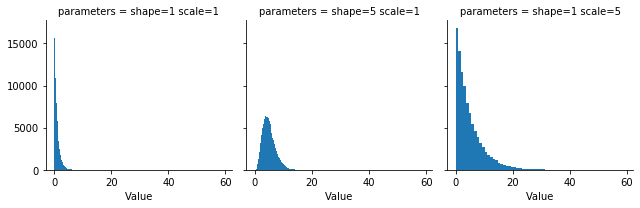

In [7]:
dfGamma = pd.DataFrame(data=gammaDistribution)

dfGammamelt = pd.melt(dfGamma,var_name='parameters',value_name='Value')


g = sns.FacetGrid(dfGammamelt,col="parameters",sharex=True)
g.map(plt.hist,'Value',cumulative=False,bins=64)

### Inverse-gamma distribution with different params

In [8]:
from scipy.stats import invgamma

invGammaDistribution={
    "shape=1 scale=1":invgamma.rvs(a=1,scale=1,size=100000),
    "shape=5 scale=1":invgamma.rvs(a=5,scale=1,size=100000),
    "shape=5 scale=5":invgamma.rvs(a=5,scale=5,size=100000),
}

### Due to plots, we can observe how value of shape and scale params affect on inverse-gamma distriibution

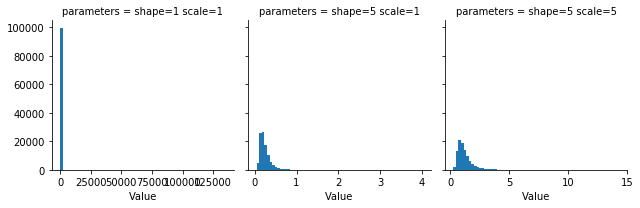

In [9]:
dfinvGamma = pd.DataFrame(data=invGammaDistribution)

dfinvGammamelt = pd.melt(dfinvGamma,var_name='parameters',value_name='Value')


g = sns.FacetGrid(dfinvGammamelt,col="parameters",sharex=False)
g.map(plt.hist,'Value',cumulative=False,bins=64)

### Impotring libs to use stan

In [10]:
import sys
import pystan
import stan_utility

import arviz as az
import scipy.stats as stats

### Some plot settings as in example 

In [237]:
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 100

### Finding parameters for Gamma distribution which 98% probability is for values between 5 and 10. In this case was used stan file with algebra_solver. It was created based on Airlines.ipynb

In [12]:
with open('prior_tune_gamma.stan', 'r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[2] deltas;
    //values between 5 and 10 with probabilty 98%, so 1% lesser than 5 and 1% greater than 10
    deltas[1] = gamma_cdf(theta[1], y[1], y[2]) -0.01; //only 1% will be lesser than 5
    deltas[2] = gamma_cdf(theta[2], y[1], y[2]) -0.99; //olny 1% will be greater than 10
    return deltas;
  }
}

data {
  vector<lower=0>[2] y_guess; // Initial guess of gamma params
  vector<lower=0>[2] theta;     // Target quantile
}

transformed data {

  vector[2] y;
  real x_r[0];
  int x_i[0];

  // Due to RuntimeError, relative tolerance was decrease to 1e-2 and max num_stes was increase do 1e6
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i,1e-10,1e-2,1e6);

  print("alpha = ", y[1]);
  print("beta = ", y[2]);
}

generated quantities {
  real alpha = y[1];
  real beta = y[2];
}



In [13]:
tuning=stan_utility.compile_model('prior_tune_gamma.stan')

Using cached StanModel


### Compilation finished without error, so model was used to find params values. Starting from alpha=2 and betha=1, values of theta is our range. It allows to determine alpha and beta

In [14]:
data=dict(y_guess=np.array([2,1]),theta=np.array([5,10]))
tuned= tuning.sampling(data=data,
                            seed=1052020,
                            algorithm="Fixed_param",
                            iter=1, 
                            warmup=0,
                            chains=1)

alpha = np.round(tuned.extract()['alpha'][0])
beta = np.round(tuned.extract()['beta'][0])

print(alpha,beta)

46.0 6.0


### Before sampling, I checked if found values make sense. Seems, everything is okay, because most values are between 5 and 10.

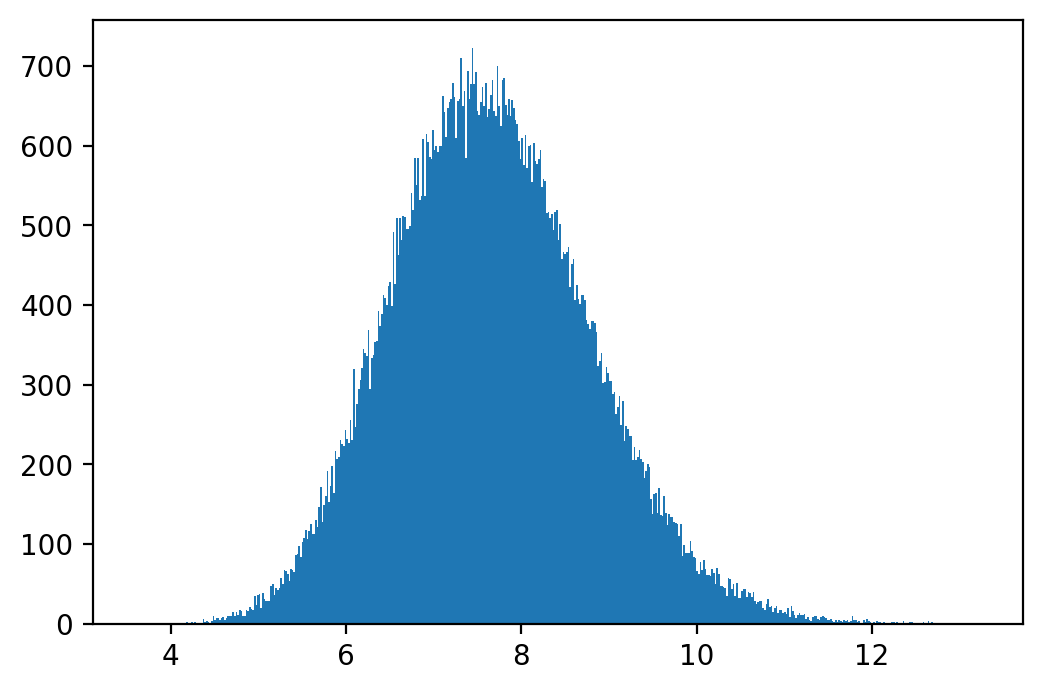

In [15]:
gamma = np.random.gamma(shape=alpha,scale=1/beta,size=100000)
gammaHist = plt.hist(gamma, bins=512)

### Model of gamma distribution in stan

In [16]:
with open('gamma.stan', 'r') as file:
    print(file.read())

data {
    real<lower=0> alpha;
    real<lower=0> beta;
}

parameters {
    real y;
}

model {
    y ~ gamma(alpha, beta);
}



In [17]:
gamma_model=stan_utility.compile_model('gamma.stan')

Using cached StanModel


### Using stan model to plot gamma distribution. We can observe that most of values are bettwen 5 and 10 and the meean is equal 7.683

Mean value : 7.683


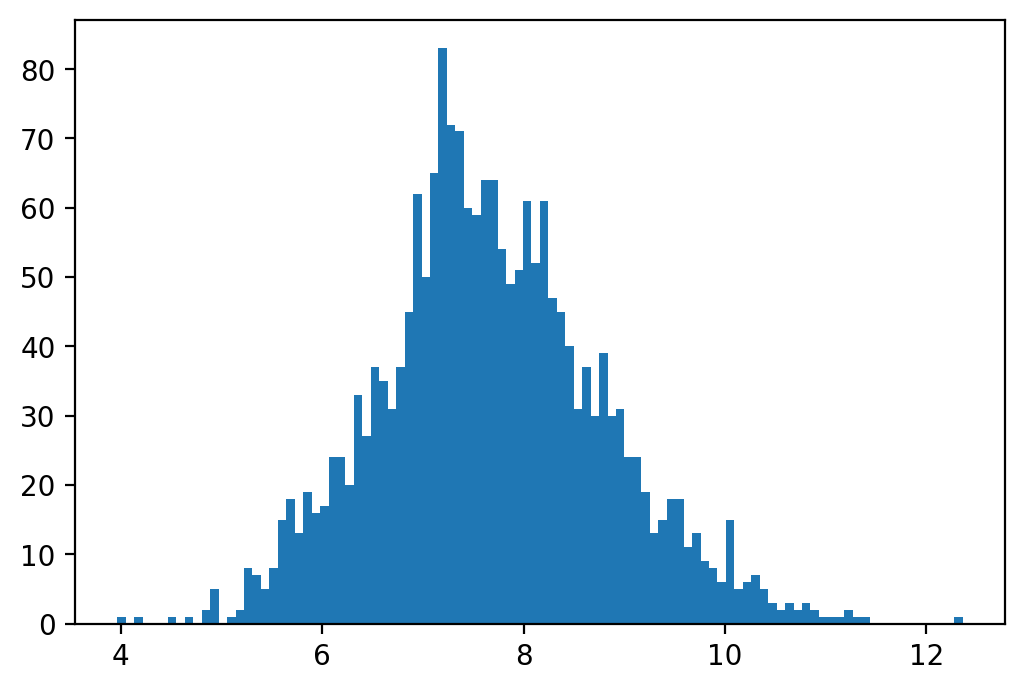

In [18]:
data=dict(alpha=alpha,
            beta = beta)
gamma_sampling=gamma_model.sampling(data=data,
                                      iter=1000,
                                      seed=10521020)

params=gamma_sampling.extract()
gammaSamplingHist=plt.hist(params['y'], bins=100)

mean_y = np.mean(params['y'])
print('Mean value : {:5.3f}'.format(mean_y))

### Finding parameters for inverse-gamma distribution which 98% probability is for values between 5 and 10. Everything was made similar as in case of gamma distribution.

In [19]:
with open('prior_tune_invgamma.stan', 'r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[2] deltas;
    //values between 5 and 10 with probabilty 98%, so 1% lesser than 5 and 1% greater than 10
    deltas[1] = inv_gamma_cdf(theta[1], y[1], y[2]) -0.01; //only 1% will be lesser than 5
    deltas[2] = inv_gamma_cdf(theta[2], y[1], y[2]) -0.99; //olny 1% will be greater than 10
    return deltas;
  }
}

data {
  vector<lower=0>[2] y_guess; // Initial guess of gamma params
  vector<lower=0>[2] theta;     // Target quantile
}

transformed data {

  vector[2] y;
  real x_r[0];
  int x_i[0];

  // Due to RuntimeError, relative tolerance was decrease to 1e-2 and max num_stes was increase do 1e6
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i,1e-10,1.2e-2,1e6);

  print("alpha = ", y[1]);
  print("beta = ", y[2]);
}

generated quantities {
  real alpha = y[1];
  real beta = y[2];
}



In [20]:
tuning2=stan_utility.compile_model('prior_tune_invgamma.stan')

Using cached StanModel


In [21]:
data=dict(y_guess=np.array([0.5,0.4]),theta=np.array([5,10]))
tuned2= tuning2.sampling(data=data,
                            seed=1052020,
                            algorithm="Fixed_param",
                            iter=1, 
                            warmup=0,
                            chains=1)

alpha_inv = np.round(tuned2.extract()['alpha'][0])
beta_inv = np.round(tuned2.extract()['beta'][0])

print(alpha_inv,beta_inv)

62.0 399.0


In [22]:
with open('invgamma.stan', 'r') as file:
    print(file.read())

data {
    real<lower=0> alpha;
    real<lower=0> beta;
}

parameters {
    real y;
}

model {
    y ~ inv_gamma(alpha, beta);
}



In [23]:
invgamma_model=stan_utility.compile_model('invgamma.stan')

Using cached StanModel


Mean value : 6.566


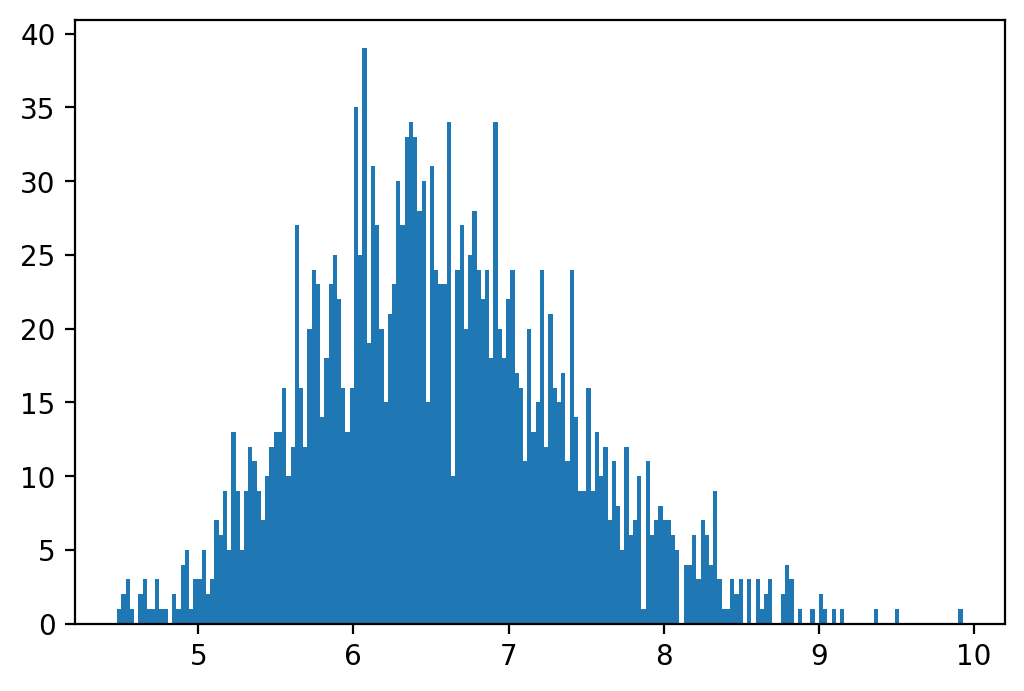

In [24]:
data=dict(alpha=alpha_inv,
            beta = beta_inv)
invgamma_sampling=invgamma_model.sampling(data=data,
                                      iter=1000,
                                      seed=10521020)

params_inv=invgamma_sampling.extract()
invgammaSamplingHist=plt.hist(params_inv['y'], bins=200)
mean_y = np.mean(params_inv['y'])
print('Mean value : {:5.3f}'.format(mean_y))

## In case inverse-gamma distribution, also most values are bettwen 5 and 10 (even 8), however more values are closer to 5, it's causing that mean is equal 6.566, where in case of gamma distribution it was 7.6.

# Ex2.

## Negativ binomial distribution

In [65]:
with open('nbino.stan', 'r') as file:
    print(file.read())

data {
    real<lower=0> alpha;
    real<lower=0> beta;
}


generated quantities {
    int<lower=0> y;
    y = neg_binomial_rng(alpha,beta);
}



### In case of negative binomial distribution mean is equal $\frac{α}{β}$ and variance is equal $\frac{α}{β^{2}}(β+1)$

In [72]:
nbino_model=stan_utility.compile_model('nbino.stan')

Using cached StanModel


### Same as in case of poisson distribution, output of negative binomial distribution is a nautral number, so for plot below, I set bins on 30, thanks to that every natural number has representation.

Mean value : 9.942


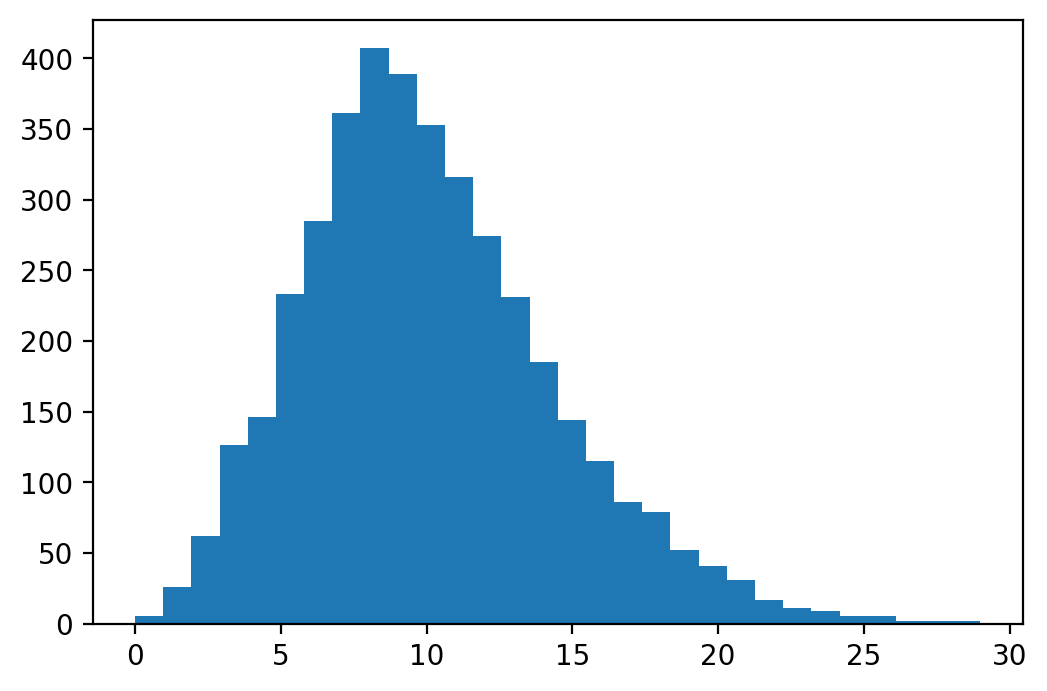

In [100]:
data=dict(alpha=10,
            beta = 1)
nbino_sample = nbino_model.sampling(data=data,
                            seed=1052020,
                            algorithm="Fixed_param",
                            iter=1000,
                            warmup=0)

params_nbino=nbino_sample.extract()
nbinoSamplingHist=plt.hist(params_nbino['y'], bins=30)

mean_y = np.mean(params_nbino['y'])
print('Mean value : {:5.3f}'.format(mean_y))

## Negative Binomial Distribution (alternative parameterization)

In [104]:
with open('nbino_alt_param.stan', 'r') as file:
    print(file.read())

data {
    real<lower=0> mu;
    real<lower=0> phi;
}


generated quantities {
    int<lower=0> y;
    y = neg_binomial_2_rng(mu,phi);
}



### In case of alternative parametrization of negative binomial distribution, there are two inpunt μ and ϕ. Mean is equal μ and variance is equal $μ+\frac{μ^{2}}{ϕ}$

In [105]:
alt_nbino_model=stan_utility.compile_model('nbino_alt_param.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5736d6e1ac77c39c06a1633ef396bdc7 NOW.


### By setting μ as 10 and ϕ as 10, we receive exactly the same values of mean(=10) and variance(=20) as in last example, so distribution is the same.

Mean value : 9.942


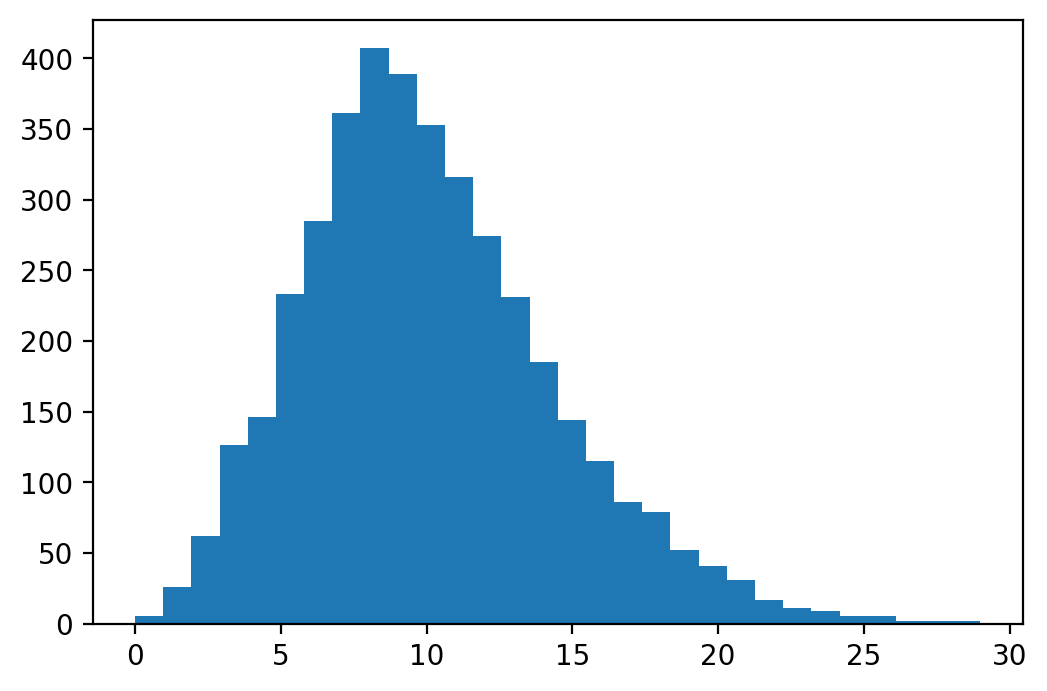

In [111]:
data=dict(mu=10,
            phi = 10)
alt_nbino_sample = alt_nbino_model.sampling(data=data,
                            seed=1052020,
                            algorithm="Fixed_param",
                            iter=1000,
                            warmup=0)

params_alt_nbino=alt_nbino_sample.extract()
alt_nbinoSamplingHist=plt.hist(params_alt_nbino['y'], bins=30)

mean_y = np.mean(params_alt_nbino['y'])
print('Mean value : {:5.3f}'.format(mean_y))

## Poisson distribution

In [117]:
with open('poisson.stan', 'r') as file:
    print(file.read())

data {
    real<lower=0> lam;
}

generated quantities {
    int<lower=0> y;
    y = poisson_rng(lam);
}



In [118]:
poisson_model=stan_utility.compile_model('poisson.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c0775b27a10e2e72319fff6534bd58c8 NOW.


Mean value : 10.004


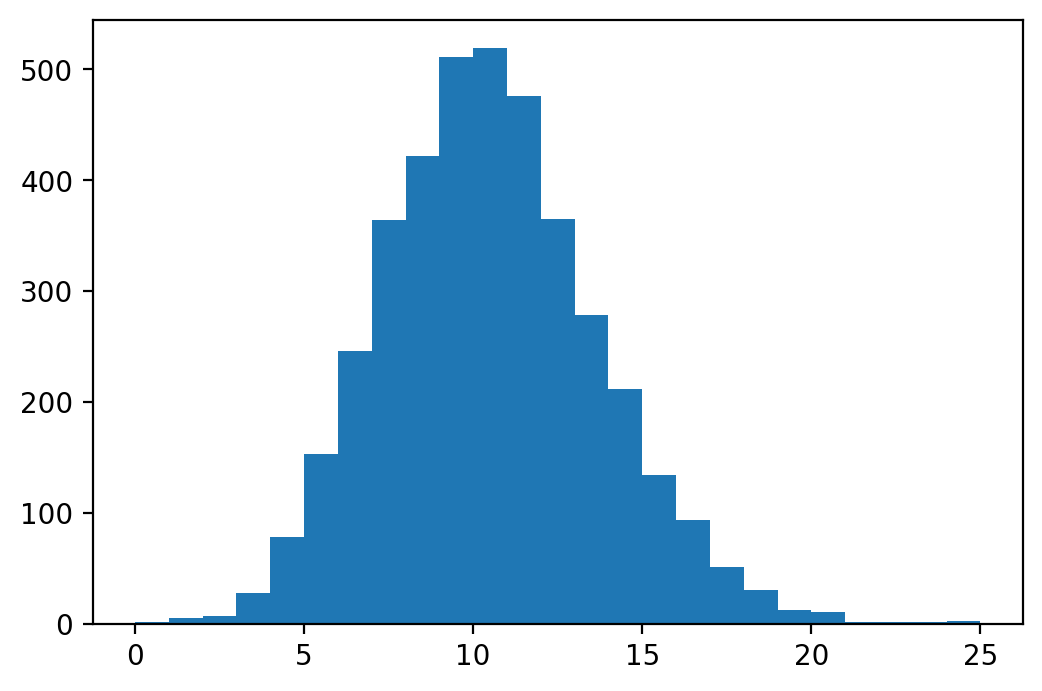

In [128]:
data=dict(lam=10)
poisson_sample = poisson_model.sampling(data=data,
                            seed=1052020,
                            algorithm="Fixed_param",
                            iter=1000,
                            warmup=0)

params_poisson=poisson_sample.extract()
poissonSamplingHist=plt.hist(params_poisson['y'], bins=25)

mean_y = np.mean(params_poisson['y'])
print('Mean value : {:5.3f}'.format(mean_y))

### By comparing results of Negative Binomial Distribution (alternative parameterization) with Poisson Distribution we can observer that for Poisson(μ) variance is lesser by $\frac{μ^{2}}{ϕ}$ than in case of negBinomial(μ,ϕ), but they have the same mean.

# Ex3.

## Student-t distribution

In [133]:
with open('student_t.stan', 'r') as file:
    print(file.read())

data {
    int<lower=0> N; //number of cases
    real<lower=0> nu;
    real mu[N];
    real<lower=0> sigma[N];
}

parameters {
    real y[N];
}

model {
    y ~ student_t(nu, mu, sigma);
}



### Observation how different parameters affect distribution

In [200]:
student_t_model=stan_utility.compile_model('student_t.stan')

Using cached StanModel


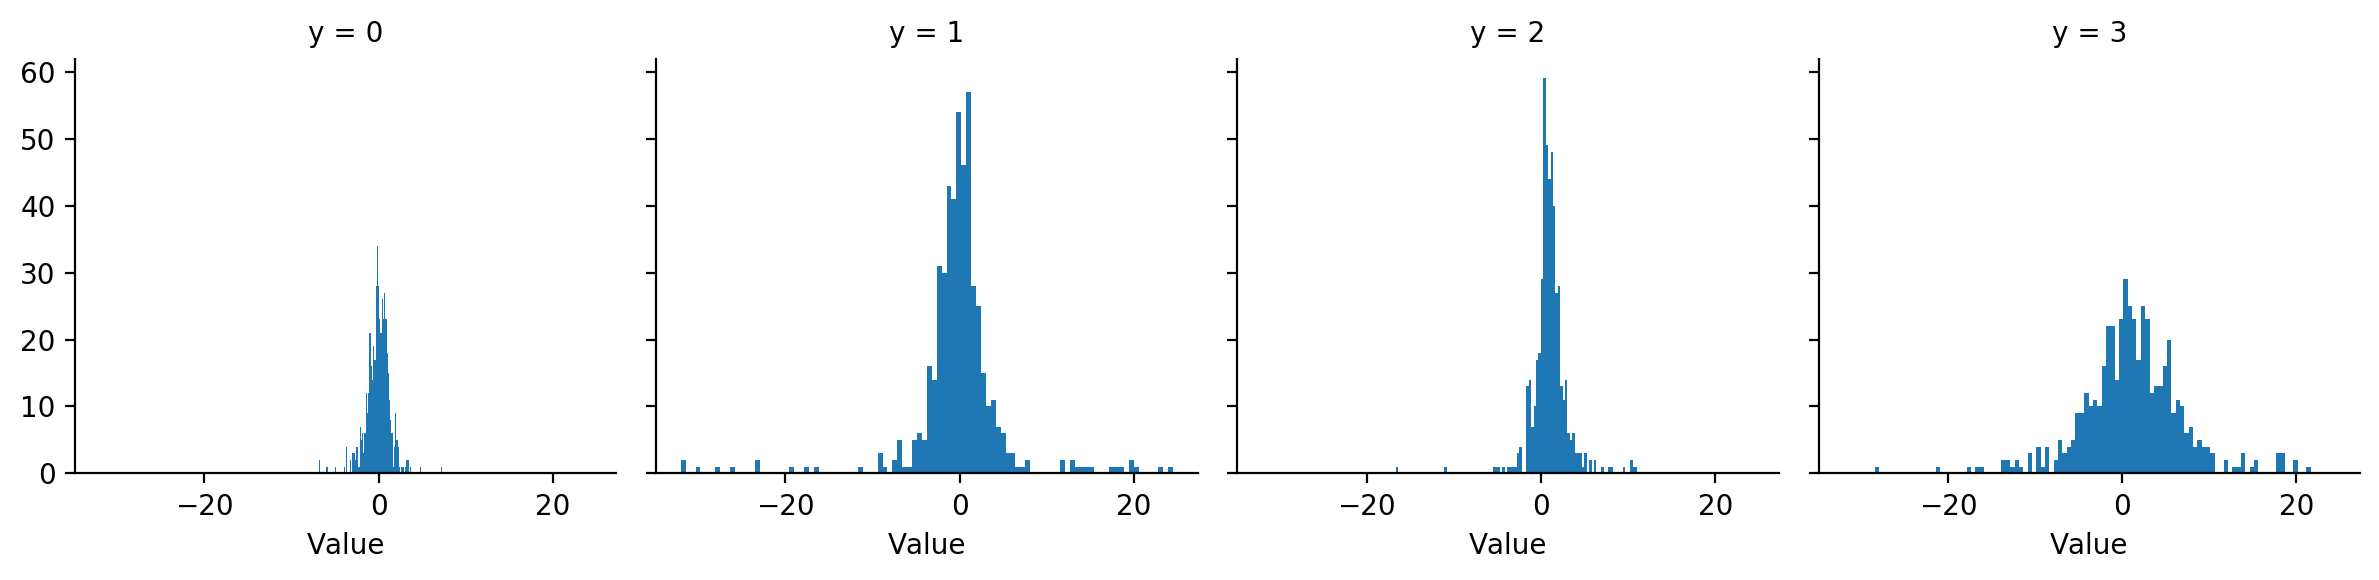

In [225]:
N = 4;
nu = 2;
mu=np.array([0,0,1,1]) #np.linspace(0,5,N)
sigma=np.array([1,2,1,3])#np.linspace(5,1,N)
data=dict(N=N,
          nu=nu,
          mu=mu,
          sigma=sigma)
student_t_sample = student_t_model.sampling(data=data,
                            seed=1052020,
                            iter=1000,
                            chains=1)

params_student_t=student_t_sample.extract()
y = params_student_t['y']
df = pd.DataFrame(y)
ymelt = pd.melt(df,var_name='y',value_name='Value')


g = sns.FacetGrid(ymelt,col="y",sharex=True)
g.map(plt.hist,'Value',cumulative=False,bins=100)
#student_tSamplingHist=plt.hist(y, bins=100)

In [227]:
with open('studentt.stan', 'r') as file:
    print(file.read())

data {
    real<lower=0> nu;
    real mu;
    real<lower=0> sigma;
}

parameters {
    real y;
}

model {
    y ~ student_t(nu, mu, sigma);
}



### Obsereation how number of iteration(samples) affect distribution for one set of parameters

In [229]:
studentt_model=stan_utility.compile_model('studentt.stan')

Using cached StanModel


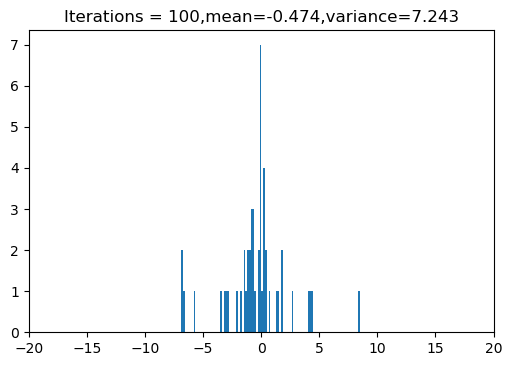

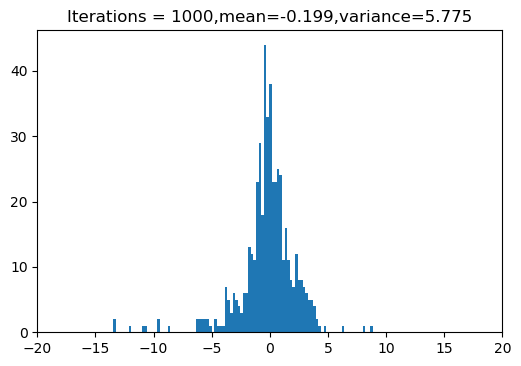

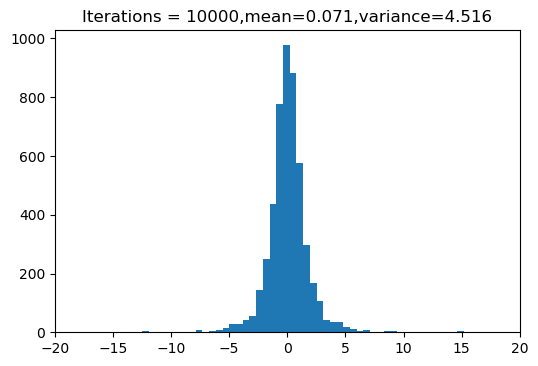

In [263]:
iteration = [100,1000,10000]
data=dict(nu=2,
          mu=0,
          sigma=1)
for i in iteration:
    studentt_sample=studentt_model.sampling(data=data,
                     iter=i,
                     chains=1,
                     seed=1052020)
    params_studentt=studentt_sample.extract()
    plt.figure()
    studenttSamplingHist=plt.hist(params_studentt['y'], bins=100)
    mean_y = np.mean(params_studentt['y'])
    var_y = np.var(params_studentt['y'])
    plt.title("Iterations = {},mean={:5.3f},variance={:5.3f}".format(i,mean_y,var_y))
    plt.xlim(-20,20)
    
    
    


### Incremention of samples causes the variance to decrease and increasing the accuracy of mean

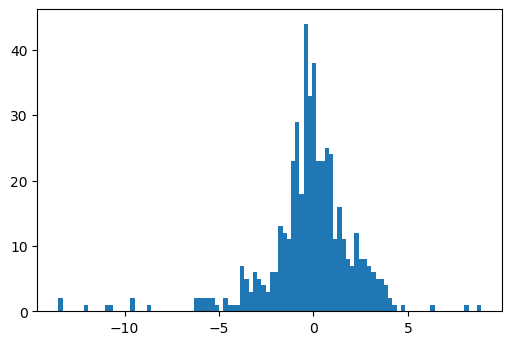

In [265]:
data=dict(nu=2,
          mu=0,
          sigma=1)
studentt_sample=studentt_model.sampling(data=data,
                                     iter=1000,
                                     chains=1,
                                     seed=1052020)
params_studentt=studentt_sample.extract()
studenttSamplingHist=plt.hist(params_studentt['y'], bins=100)